In [1]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from qa_qc_lib.qa_qc_seismic import *

In [2]:
def generate_random_nonintersecting_polygon(num_sides, min_side_length, max_side_length):
    if num_sides < 3:
        raise ValueError("A polygon must have at least 3 sides.")

    # Generate random side lengths
    side_lengths = np.random.uniform(min_side_length, max_side_length, num_sides)

    # Calculate the total perimeter of the polygon
    total_perimeter = np.sum(side_lengths)

    # Calculate the angles between the sides
    angles = np.random.uniform(0, 360, num_sides)

    # Generate the cumulative angles for vertex positions
    cumulative_angles = np.cumsum(angles)

    # Generate the coordinates of the polygon vertices
    x_coords = total_perimeter * np.cos(np.radians(cumulative_angles))
    y_coords = total_perimeter * np.sin(np.radians(cumulative_angles))

    # Close the polygon
    x_coords = np.append(x_coords, x_coords[0])
    y_coords = np.append(y_coords, y_coords[0])

    # Check if any of the sides intersect, and if so, regenerate the polygon
    for i in range(num_sides):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % num_sides], y_coords[(i + 1) % num_sides]
        for j in range(i + 2, num_sides):
            x3, y3 = x_coords[j], y_coords[j]
            x4, y4 = x_coords[(j + 1) % num_sides], y_coords[(j + 1) % num_sides]
            if do_segments_intersect(x1, y1, x2, y2, x3, y3, x4, y4):
                return generate_random_nonintersecting_polygon(num_sides, min_side_length, max_side_length)

    return x_coords, y_coords

def do_segments_intersect(x1, y1, x2, y2, x3, y3, x4, y4):
    # Check if two line segments intersect using the cross product method
    def cross_product(x1, y1, x2, y2):
        return x1 * y2 - x2 * y1

    d1 = cross_product(x4 - x3, y4 - y3, x1 - x3, y1 - y3)
    d2 = cross_product(x4 - x3, y4 - y3, x2 - x3, y2 - y3)
    d3 = cross_product(x2 - x1, y2 - y1, x3 - x1, y3 - y1)
    d4 = cross_product(x2 - x1, y2 - y1, x4 - x1, y4 - y1)

    if (d1 * d2 < 0) and (d3 * d4 < 0):
        return True
    return False


def add_noise_to_polygon(polygon_points, noise_factor=0.1):
    x_coords, y_coords = zip(*polygon_points)
    noise_x = np.random.uniform(-noise_factor, noise_factor, len(x_coords))
    noise_y = np.random.uniform(-noise_factor, noise_factor, len(y_coords))

    x_coords_noisy = [x + noise for x, noise in zip(x_coords, noise_x)]
    y_coords_noisy = [y + noise for y, noise in zip(y_coords, noise_y)]

    return list(zip(x_coords_noisy, y_coords_noisy))
    

def build_polygon_from_points(x_coords, y_coords):
    min_x, max_x = min(x_coords), max(x_coords)
    min_y, max_y = min(y_coords), max(y_coords)

    rectangle_points = [(min_x, min_y), (min_x, max_y), (max_x, max_y), (max_x, min_y)]
    return rectangle_points

In [3]:
file_path = 'data/Глубинный куб NP cropped'
# Example usage:
num_sides = 5
min_side_length = 1
max_side_length = 5
x_coords, y_coords = generate_random_nonintersecting_polygon(num_sides, min_side_length, max_side_length)

license_area_poly = list(zip(x_coords*5000, y_coords*500))
license_area_poly

[(28925.972874700365, -5289.005494240505),
 (40937.949524854805, -4425.103509816428),
 (59557.746277158345, -932.4412954398671),
 (58277.28464409076, 1542.1670242556397),
 (-37756.769374520714, -4699.463995986969),
 (28925.972874700365, -5289.005494240505)]

In [4]:
seism_data_qa_qc = QA_QC_seismic(file_path)

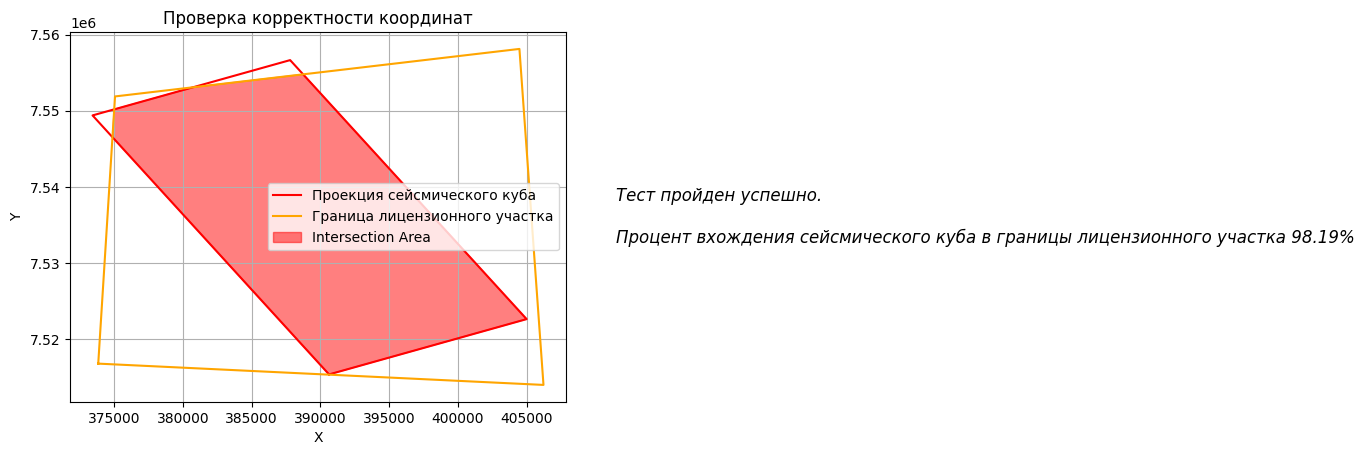

In [10]:
seism_data_qa_qc.license_area_poly = add_noise_to_polygon(build_polygon_from_points(seism_data_qa_qc.coordinate_x, seism_data_qa_qc.coordinate_y), noise_factor=5000)

seism_data_qa_qc.coordinate_validation()

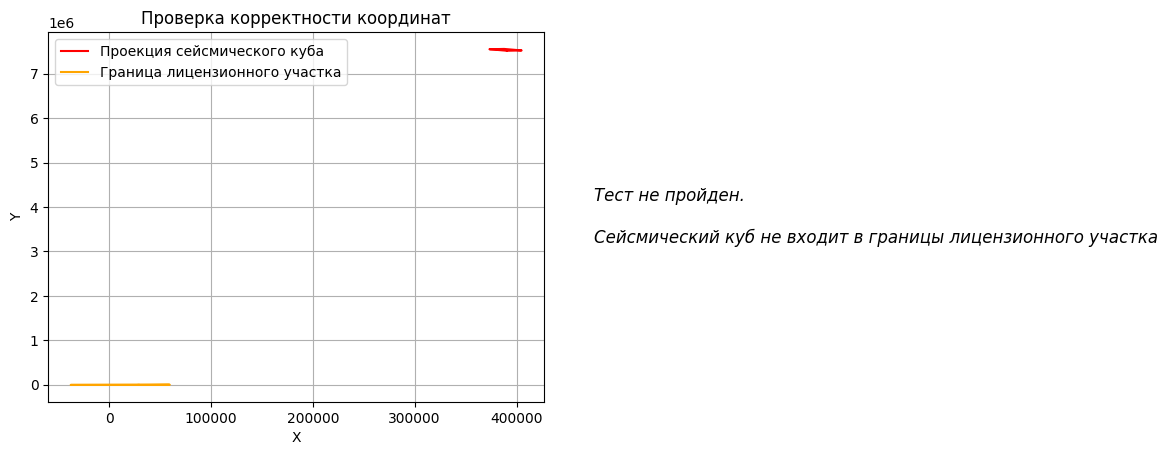

In [6]:
seism_data_qa_qc.license_area_poly = license_area_poly
seism_data_qa_qc.coordinate_validation()